# Using Pandana to Measure Multi-Modal Accessibility with Automobile, Pedestrian, and Transit Networks

This session introduces the Pandana Library (Pandas Network Analysis), developed as part of the Urban Data Science Toolkit.

The session covers: 

* acquisition of OpenStreetMap (OSM) street network data 
* nearest neighbor 
* cumulative accessibility 
* queries on auto, pedestrian, and transit networks.

### Question: Do you think WalkScore is useful? Why? 

Check-in time: http://bitly.com/cp255

Pandana is a Python and C++ network analysis tool that can compute network accessibility using: 1) shortest path queries between ODs for any number of nodes within a search radius; and 2) aggregation queries using a cumulative opportunities accessibility method.  

A variety of statistics and can be used including sum, average, standard deviation, and count along with a number of distance decay functions such as linear and exponential. Pandana requires: 1) a set of OD node coordinates (e.g. based on addresses or Census block centroids) for which accessibility will be computed between and can include variables of interest such as socioeconomic data or business establishments that can be queried or aggregated; and 2) a network of nodes and weighted edges used for network routing. The OD nodes are connected to the nearest node in the graph network.

Pandana calculates the shortest path (e.g. lowest cost path) between ODs over a hierarchical network using the contraction hierarchies algorithm. Contraction hierarchies allows for rapid network calculations over large geographic extents and is an improvement upon the more traditional Dijkstra's shortest path algorithm. 

Pandana can be acquired as a open source library here: https://github.com/UDST/pandana

For more detailed information on Pandana see:

Fletcher Foti, Paul Waddell and Dennis Luxen. 2012. ["A Generalized Computational Framework for Accessibility: From the Pedestrian to the Metropolitan Scale"](http://onlinepubs.trb.org/onlinepubs/conferences/2012/4thITM/Papers-A/0117-000062.pdf)

In [1]:
#!pip install pandana==0.3

In [4]:
import pandana as pdna
# from pandana.loaders import osm
import pandas as pd
from ipywidgets import FloatSlider, interact
from IPython.core.display import display
from urbansim.utils import misc
import matplotlib.pyplot as plt
import matplotlib
#from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [8]:
pdna.__version__

'0.4.1'

In [2]:
#!pip install matplotlib==2.0.2

In [5]:
matplotlib.__version__

'2.0.2'

In [6]:
def plot_nodes(x_data=None,y_data=None,node_size=15,node_color='black',color_map=None,edge_color=None):
    fig, ax = plt.subplots()
    ax.scatter(x_data, y_data, s=node_size, c=node_color,
                   alpha=1, edgecolor=edge_color,cmap=color_map,
                   zorder=3)
    plt.show()
    return fig, ax

Set data path

In [7]:
data_path = 'data/'

# Pandana networks

## Nodes

Pandana nodes consist of a unique "id" with spatial coordinates (latitude and longitude). Nodes are the vertices of a graph network representing street intersections.

In [8]:
nodes = pd.DataFrame({'id':[1,2,3,4],
                      'x':[-122.302578,-122.177008,-122.181374,-122.184170],
                      'y':[37.560184,37.481747,37.483689,37.484536]})

In [9]:
nodes

,id,x,y
0,1,-122.302578,37.560184
1,2,-122.177008,37.481747
2,3,-122.181374,37.483689
3,4,-122.184170,37.484536


Plot the nodes on a map

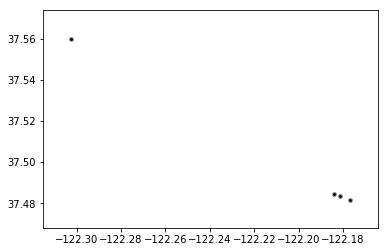

(<matplotlib.figure.Figure at 0x1a1be65278>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1be65ac8>)

In [10]:
plot_nodes(x_data=nodes['x'],
           y_data=nodes['y'],
           node_size=15,
           node_color='black',
           color_map=None,
           edge_color='#999999')

## Edges

Pandana edges consist of a "from" node id and "to" node id column which is used to denote direction and an impedance column or weight column representing a friction factor for travel between the two nodes, in this case distance in meters, but this can also be travel time or a utility value. Edges are the connections between nodes representing streets and pathways.

In [11]:
edges = pd.DataFrame({'from':[1,2,3],
                      'to':[2,3,4],
                      'distance_m':[3000,6000,8000]})
edges

,from,to,distance_m
0,1,2,3000
1,2,3,6000
2,3,4,8000


You can convert the edge weights to represent any unit  
for example convert distance into pedestrian travel time at 3 MPH

In [12]:
SPEED_MPH = 3
edges['travel_time_min'] = (edges['distance_m']/1609.34) / SPEED_MPH * 60
edges

,from,to,distance_m,travel_time_min
0,1,2,3000,37.282364
1,2,3,6000,74.564728
2,3,4,8000,99.419638


Pandana edges can be either "one way" or "two way". Lets convert the one way edge table above to a two way edge table

In [13]:
edges = edges.append(edges.rename(inplace=False,columns={'from':'to','to':'from'})).reset_index(drop=True)
edges

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


,distance_m,from,to,travel_time_min
0,3000,1,2,37.282364
1,6000,2,3,74.564728
2,8000,3,4,99.419638
3,3000,2,1,37.282364
4,6000,3,2,74.564728
5,8000,4,3,99.419638


# Nearest neighbor query

### Download street network data: Auto network

Use Pandana to acquire the auto street network within a bounding box for Alameda County, CA from OpenStreetMap. Then remove low connectivity nodes from the graph network and save as a local hdf5 file. "drive" network type extracts auto only OSM street network components. "Two_way" denotes each edge in the network is traversable in both directions with the same weight.

Note that Pandana has some similar functionality as OSMnx for acquiring OSM network data, but is focused on setting up the network for fast accessibility calculations.

Below is a handy website for finding the bounding box of any place you might be interested in. 

Bounding box from: http://boundingbox.klokantech.com/

The cell below contains the code to generate the network, but in the interest of time we will skip this cell and get a saved version.

In [14]:
'''
%%time
h5file = 'osm_drive_2way_subset.h5'
network = pdna.loaders.osm.network_from_bbox(lat_min=37.454539, 
                                                lng_min=-122.342665, 
                                                lat_max=37.905668, 
                                                lng_max=-121.469214, 
                                                network_type='drive', 
                                                two_way=True)
lcn = network.low_connectivity_nodes(10000, 10, imp_name='distance')
network.save_hdf5(data_path+h5file, rm_nodes=lcn)
print 'OSM data save completed:', data_path, h5file
'''

"\n%%time\nh5file = 'osm_drive_2way_subset.h5'\nnetwork = pdna.loaders.osm.network_from_bbox(lat_min=37.454539, \n                                                lng_min=-122.342665, \n                                                lat_max=37.905668, \n                                                lng_max=-121.469214, \n                                                network_type='drive', \n                                                two_way=True)\nlcn = network.low_connectivity_nodes(10000, 10, imp_name='distance')\nnetwork.save_hdf5(data_path+h5file, rm_nodes=lcn)\nprint 'OSM data save completed:', data_path, h5file\n"

Load previously generated auto network

In [15]:
%%time
h5file = 'osm_drive_2way_subset.h5'
osm_drive_nodes = pd.HDFStore(data_path+h5file).nodes
osm_drive_edges = pd.HDFStore(data_path+h5file).edges

CPU times: user 175 ms, sys: 68.8 ms, total: 244 ms
Wall time: 301 ms


## Inspect the network

### Nodes

In [16]:
print('Total number of nodes:', len(osm_drive_nodes))
osm_drive_nodes.head()

Total number of nodes: 94981


,x,y
b'id',,
281266,-122.302578,37.560184
26028129,-122.177008,37.481747
26028133,-122.181374,37.483689
26029745,-122.184170,37.484536
26029880,-122.284735,37.541234


### Edges

In [17]:
print('Total number of edges:', len(osm_drive_edges))
osm_drive_edges.head()

Total number of edges: 135169


from         to     distance
281266   65358141     281266   65358141   321.454500
         702274215    281266  702274215  1327.931491
26028129 26028133   26028129   26028133   441.690295
         65385638   26028129   65385638   236.607166
26028133 26029745   26028133   26029745   264.163233

## Initialize a Pandana network

Initialize the Pandana network object to be used in the nearest neighbor query

In [18]:
%%time
drive_net = pdna.Network(osm_drive_nodes["x"], 
                   osm_drive_nodes["y"], 
                   osm_drive_edges["from"], 
                   osm_drive_edges["to"],
                   osm_drive_edges[["distance"]],twoway=True)
print('Network initialized')

/anaconda3/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/anaconda3/lib/python3.6/site-packages/pandana/network.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/anaconda3/lib/python3.6/site-packages/pandana/network.py:85: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/anaconda3/lib/python3.6/site-packages/pandana/network.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


Network initialized
CPU times: user 8.44 s, sys: 65.5 ms, total: 8.5 s
Wall time: 8.49 s


## Load input data

### POI data

OSHPD Hospitals 2012 from: https://www.oshpd.ca.gov/documents/HWDD/GIS/HealthcareFacilities201210.zip  
CPAD Parks 2016 from: http://atlas.ca.gov/casil/planning/Land_Ownership/GreenInfoNetworkProject/CPAD-2016a-June2016/CPAD_2016a.zip

Shapefiles have been post-processed by converting each shapefile to a csv and adding explicit centroid coordinates columns.

Read data into a Pandas dataframe and subset for Alameda county and other attributes.

In [19]:
hospitals = pd.read_csv(data_path+'oshpd_points.csv')
hospitals = hospitals[hospitals['COUNTY'] == 'Alameda']
hospitals = hospitals[hospitals['TYPE'] == 'Hospital']
hospitals = hospitals[hospitals['FAC_STATUS'] == 'Open']
print('Loaded', str(len(hospitals)), 'hospitals.')

Loaded 24 hospitals.


In [20]:
hospitals.head()

,X,Y,OBJECTID,OSHPD_ID,LICENSE_NO,LICENSEID,ADDRESSID,FACILITYID,ENTITYID,PERM_ID,...,FDD,HSA,SPA,RUCA,MA,UA,CAH,DSH,FQHC,FQHC_LOOK
14,-122.231187,37.799165,7462,106010846,140000046,53955.0,15,8,66.0,11288,...,CEN,5,0,0,1,1,0,1,0,0
15,-122.120557,37.707885,7463,106010811,140000046,53955.0,11,6,66.0,11268,...,CEN,5,0,0,1,1,0,0,0,0
16,-122.257997,37.824315,7464,106010856,140000052,54767.0,17,9,1453.0,11296,...,CEN,5,0,0,1,1,0,0,0,0
18,-122.093367,37.625925,7466,106010858,140000053,54766.0,19,10,1453.0,11295,...,CEN,5,0,0,1,1,0,0,0,0
19,-121.974817,37.550545,7467,106014132,140000053,54766.0,44,23,1453.0,14509,...,CEN,5,0,0,1,1,0,0,0,0


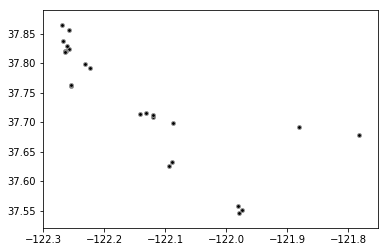

(<matplotlib.figure.Figure at 0x1a297b6b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a297b66d8>)

In [21]:
plot_nodes(x_data=hospitals['X'],
           y_data=hospitals['Y'],
           node_size=15,
           node_color='black',
           color_map=None,
           edge_color='#999999')

In [22]:
parks = pd.read_csv(data_path+'cpad_points.csv')
parks = parks[parks['COUNTY'] == 'Alameda']
parks = parks[parks['ACCESS_TYP'] == 'Open Access']
print('Loaded', str(len(parks)), 'parks.')

Loaded 556 parks.


In [23]:
parks.head()

,WKT,ACCESS_TYP,UNIT_ID,UNIT_NAME,SUID_NMA,AGNCY_ID,AGNCY_NAME,AGNCY_LEV,AGNCY_TYP,AGNCY_WEB,...,MNG_AG_ID,MNG_AGENCY,PARK_URL,COUNTY,ACRES,LABEL_NAME,DES_TP,GAP_STS,XCOORD,YCOORD
23,POINT (-121.91827114499223 37.479020716144205),Open Access,12981,Booster Park,16273,1113,"Fremont, City of",City,City Agency,http://www.fremont.gov/316/Parks,...,1113,"Fremont, City of",NaN,Alameda,8.178,Booster Park,Local Park,4.0,-121.918271,37.479021
25,POINT (-121.8974876973582 37.649989485289161),Open Access,44185,Fawn Hills Park,18854,1257,"Pleasanton, City of",City,City Agency,http://www.cityofpleasantonca.gov/,...,1257,"Pleasanton, City of",NaN,Alameda,4.875,Fawn Hills Park,Local Park,4.0,-121.897488,37.649989
70,POINT (-122.03929437429197 37.549850592549276),Open Access,23667,MacGregor Playfields,21628,1221,"Newark, City of",City,City Agency,http://www.ci.newark.ca.us/departments/recreat...,...,1221,"Newark, City of",NaN,Alameda,7.401,MacGregor Playfields,Local Recreation Area,4.0,-122.039294,37.549851
108,POINT (-121.72230367643789 37.527171205806965),Open Access,29544,Ohlone Regional Wilderness,10826,2032,East Bay Regional Park District,Special District,Regional Park District,http://www.ebparks.org/,...,2032,East Bay Regional Park District,http://www.ebparks.org/parks/ohlone,Alameda,5442.916,Ohlone Reg. Wilderness,Local Conservation Area,2.0,-121.722304,37.527171
127,POINT (-122.14244375202195 37.741189943450522),Open Access,13404,Dunsmuir Estate Park,18309,1228,"Oakland, City of",City,City Agency,http://www2.oaklandnet.com/Government/o/opr/in...,...,1228,"Oakland, City of",NaN,Alameda,25.146,Dunsmuir Estate Park,Local Park,4.0,-122.142444,37.741190


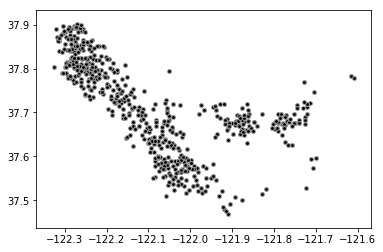

(<matplotlib.figure.Figure at 0x1a29278dd8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a292787b8>)

In [24]:
plot_nodes(x_data=parks['XCOORD'],
           y_data=parks['YCOORD'],
           node_size=15,
           node_color='black',
           color_map=None,
           edge_color='#999999')

## Calculate nearest neighbor

For each node on the network calculate the distance to the nearest 2 hospital and 2 park features within a 10 km network search radius.

Initialize the POIs on the network for two types of POIs with a max query distance of 10 km meters for the nearest 2 POIs. Then set the POIs on the network.

In [25]:
%%time
drive_net.set_pois(maxdist=10000,maxitems=2,category="parks", x_col=parks['XCOORD'], y_col=parks['YCOORD'])
drive_net.set_pois(maxdist=10000,maxitems=2,category="hospitals", x_col=hospitals['X'], y_col=hospitals['Y'])

CPU times: user 40 ms, sys: 6.14 ms, total: 46.1 ms
Wall time: 45.5 ms


/anaconda3/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


Calculate the distance between each network node and the nearest 2 POIs for each category within a 10 km network radius.

In [26]:
%%time
nearest_parks = drive_net.nearest_pois(distance=10000, category="parks", num_pois=2,max_distance=0)
nearest_hospitals = drive_net.nearest_pois(distance=10000, category="hospitals", num_pois=2,max_distance=0)

CPU times: user 3.24 s, sys: 31.1 ms, total: 3.27 s
Wall time: 3.26 s


## View results

Inspect results: Network node id and network distance to first and second closest hospital within 10 km

In [27]:
nearest_hospitals[nearest_hospitals[1]>0].head()

,1,2
b'id',,
26819598,7406.579102,9121.921875
29891370,4553.059082,9030.510742
29891391,6339.383789,9458.651367
29891439,1663.937012,1744.010010
30029450,5118.064941,8369.219727


## View results on a map

### Oakland: Distance to nearest hospital within 10 km

In [28]:
bbox = (37.6991981,-122.3426649,37.8847249,-122.1149234) #oakland
drive_net.plot(nearest_hospitals[1], 
         bbox=bbox,
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'BrBG_r','s':8,'edgecolor':'none'})

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

### Alameda County: Distance to nearest hospital within 10 km

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a1f4cc320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1cac8ef0>)

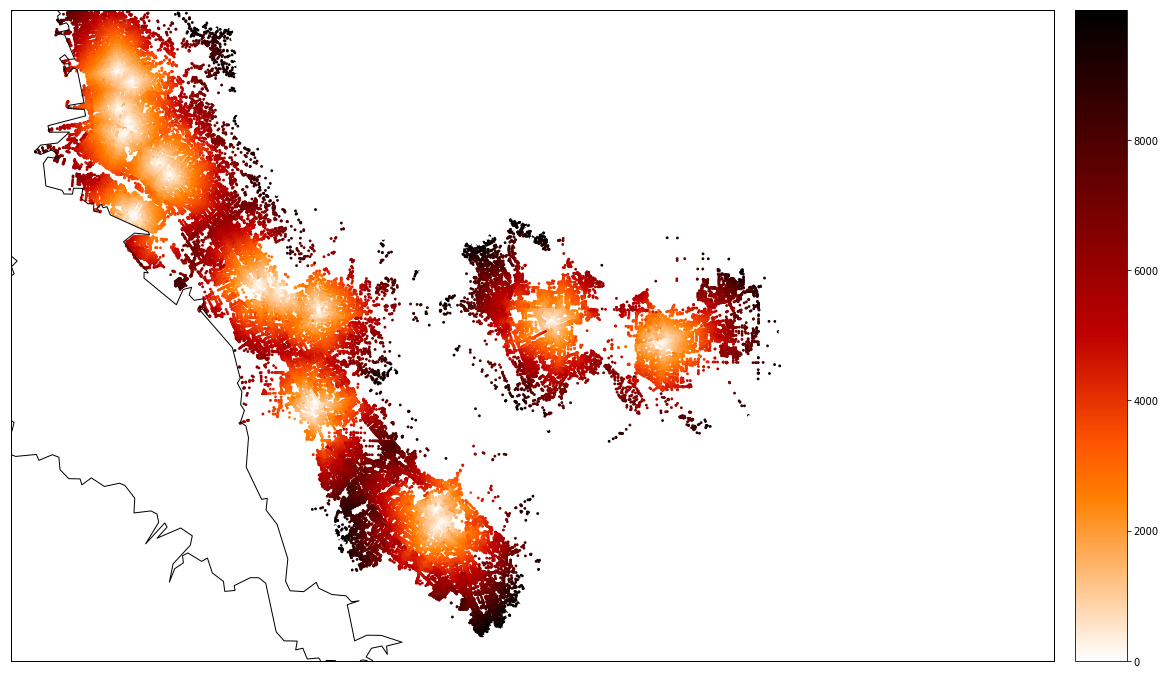

In [31]:
drive_net.plot(nearest_hospitals[1], 
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

### Alameda County: Distance to nearest park within 10 km

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a21413dd8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1f4918d0>)

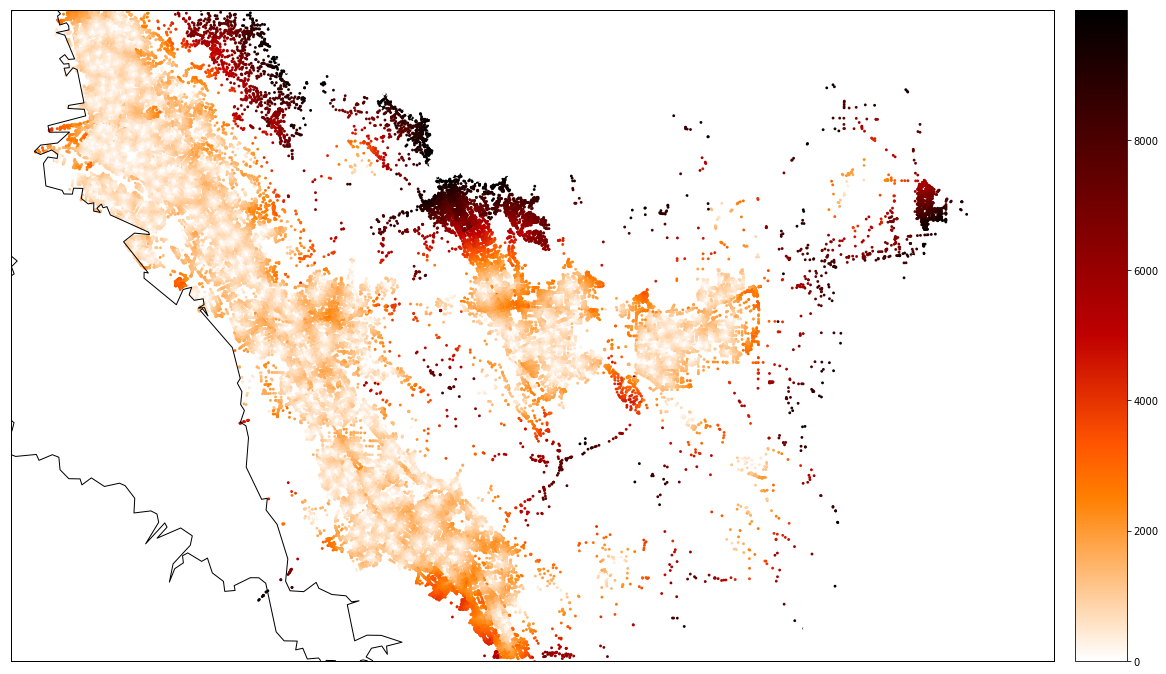

In [32]:
drive_net.plot(nearest_parks[1], 
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

# #3 Cumulative opportunities accessibility query

## Load input variable and network data

Data includes Census blocks for Alameda County with block level synthesized job and household data (as agents)

In [36]:
%%time
blocks = pd.read_csv(data_path+'blocks_subset.csv', index_col='block_id')
jobs = pd.read_csv(data_path+'jobs_subset.csv', index_col='job_id')
households = pd.read_csv(data_path+'households_subset.csv', index_col='block_id')
print('Loaded',str(len(blocks)),'blocks',str(len(jobs)),'jobs',str(len(households)),'households')

Loaded 32418 blocks 922291 jobs 766484 households
CPU times: user 1.26 s, sys: 139 ms, total: 1.4 s
Wall time: 1.4 s


## Inspect the data

In [37]:
blocks.head()

,x,y,residential_units,non_residential_sqft,own_multifam_1940s,own_multifam_1950s,own_multifam_1960s,own_multifam_1970s,own_multifam_1980s,own_multifam_1990s,...,rnt_singlfam_1950s,rnt_singlfam_1960s,rnt_singlfam_1970s,rnt_singlfam_1980s,rnt_singlfam_1990s,rnt_singlfam_2000s,rnt_singlfam_post2010,rnt_singlfam_pre1939,res_rents,res_values
block_id,,,,,,,,,,,,,,,,,,,,,
60133452031015,-122.034088,37.796320,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
60014511013346,-121.584289,37.589689,3,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,892.0,1100001.1
60014507013074,-121.732921,37.565688,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
60133451111000,-121.956067,37.755973,308,139000,0,0,0,0,0,0,...,0,6,3,30,0,0,0,0,2201.1,799400.0
60014371011019,-122.149724,37.654760,1,362500,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1776.0,573900.0


In [38]:
jobs.head()

,block_id,sector_id
job_id,,
1,60014001001007,12
2,60014001001007,12
3,60014001001007,12
4,60014001001007,12
5,60014001001007,12


In [39]:
households.head()

,household_id,serialno,persons,cars,income,race_of_head,age_of_head,workers,children,tenure,recent_mover
block_id,,,,,,,,,,,
60816100001000,2,2.013000e+12,1.0,2.0,100000.0,1.0,43.0,1.0,0.0,1,0
60014251041009,97,2.013001e+12,1.0,1.0,65000.0,1.0,64.0,1.0,0.0,1,0
60014515033001,126,2.009000e+12,1.0,1.0,19200.0,1.0,64.0,0.0,0.0,1,0
60014419262000,142,2.013001e+12,1.0,1.0,14000.0,9.0,60.0,1.0,0.0,1,1
60014305002004,257,2.009001e+12,1.0,1.0,6000.0,1.0,93.0,0.0,0.0,1,0


## Create accessibility variables of interest and set them on the network

Aggregate job and worker agents to the block level

In [40]:
blocks['node_id'] = drive_net.get_node_ids(blocks['x'], blocks['y'])
blocks['jobs'] = jobs.groupby(jobs.block_id).size()
blocks['workers'] = households.groupby(households.index).workers.sum()
blocks = blocks.fillna(0)

set the variables on the Pandana network

In [41]:
drive_net.set(blocks.node_id, variable = blocks.jobs, name='jobs')
drive_net.set(blocks.node_id, variable = blocks.workers, name='workers')

## Precompute the network

Precompute the distance query from 0 to 1000 m to speed up the query. Note: This is memory intensive, so I limited the distance to 1KM to run on datahub with only 1GB of memory.

In [39]:
%%time
drive_net.precompute(1000)

CPU times: user 1.56 s, sys: 50.3 ms, total: 1.61 s
Wall time: 1.61 s


## Calculate cumulative accessibility

For each block, calculate the cumulative number of total jobs accessible for blocks within a 1, 2, 3 km network radius.

In [40]:
%%time
jobs_500 = drive_net.aggregate(500, 
                              type='sum', 
                              decay='linear', 
                              name = 'jobs')
jobs_1000 = drive_net.aggregate(1000, 
                              type='sum', 
                              decay='linear', 
                              name = 'jobs')

CPU times: user 263 ms, sys: 3.89 ms, total: 267 ms
Wall time: 265 ms


Do the same for the number of workers

In [41]:
%%time
workers_1000 = drive_net.aggregate(1000, 
                              type='sum', 
                              decay='linear', 
                              name = 'workers')

CPU times: user 177 ms, sys: 1.88 ms, total: 179 ms
Wall time: 180 ms


## View results

Combine all results into a Pandas dataframe

In [42]:
results_drive = pd.DataFrame({'jobs_500':misc.reindex(jobs_500, blocks.node_id),
                              'jobs_1000':misc.reindex(jobs_1000, blocks.node_id),
                              'workers_1000':misc.reindex(workers_1000, blocks.node_id)})
results_drive.tail()

,jobs_1000,jobs_500,workers_1000
block_id,,,
60855112001002,265.445112,15.651836,610.435682
60855046021011,0.994995,0.000000,0.000000
60855044222007,303.657921,55.519474,735.959535
60855044221003,388.591625,290.058730,534.520814
60855044203011,0.000000,0.000000,0.000000


## View results on a map

### Alameda County: Total jobs within 1/2 km

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a235534e0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a21a01f60>)

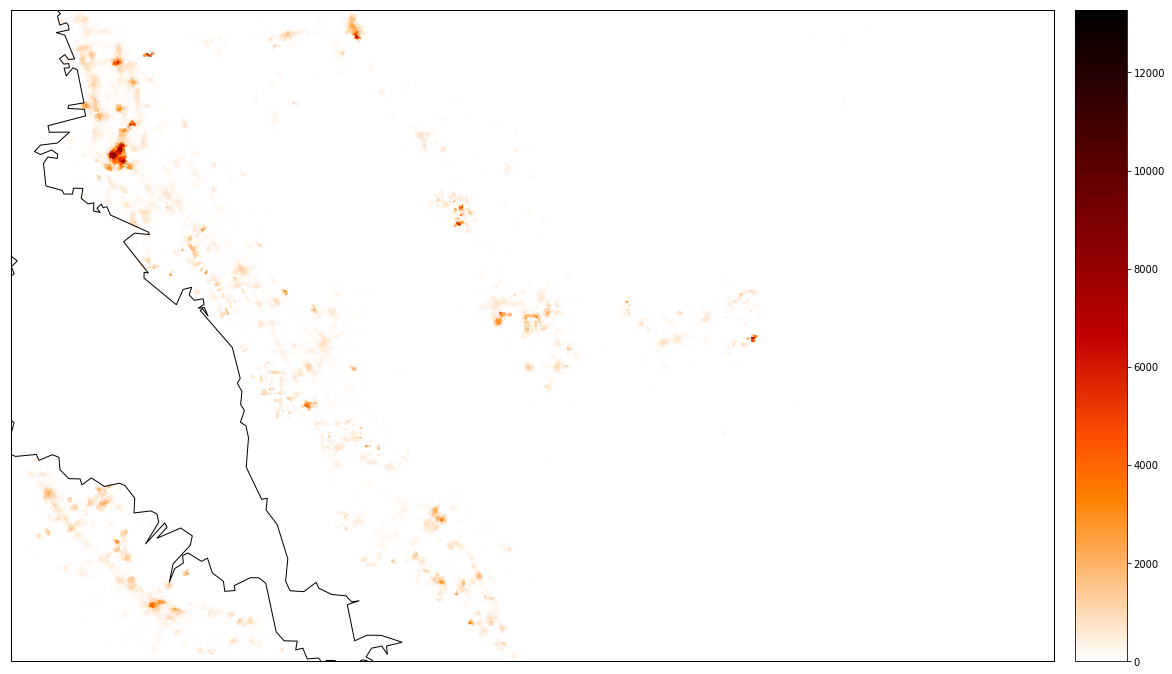

In [43]:
drive_net.plot(jobs_500, 
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

### Alameda County: Total jobs within 1 km

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a21381dd8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a226d82b0>)

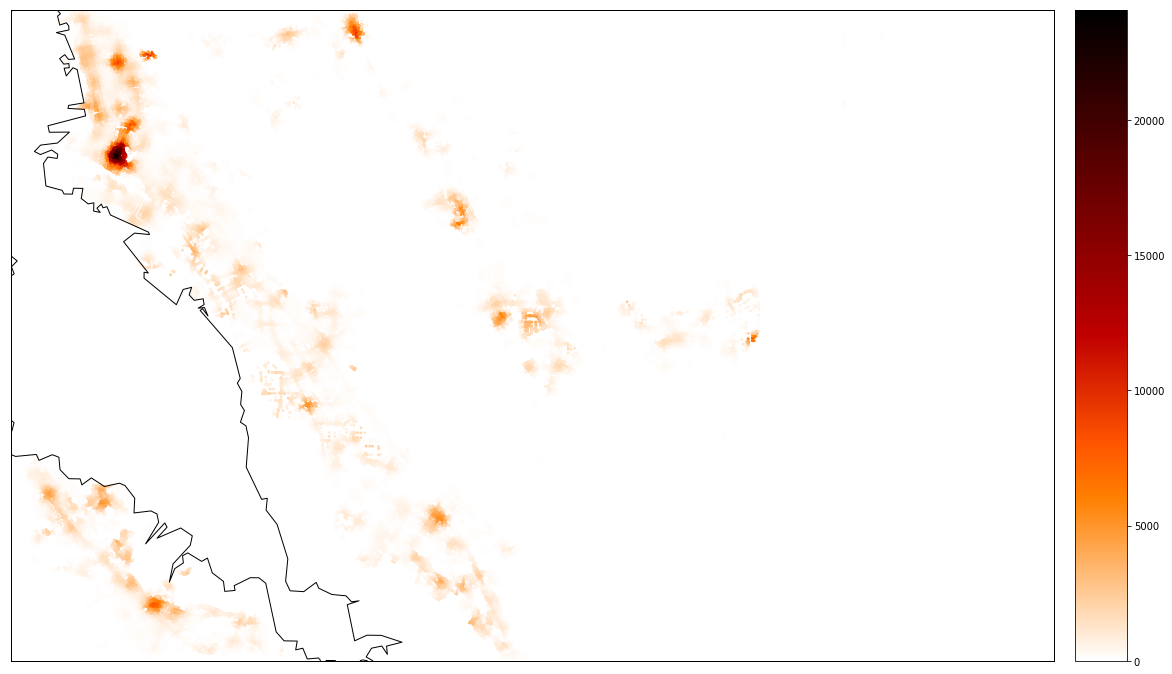

In [44]:
drive_net.plot(jobs_1000, 
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

### Alameda County: Total workers within 1 km

/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/waddell/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


(<mpl_toolkits.basemap.Basemap at 0x1a275fc390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a21858080>)

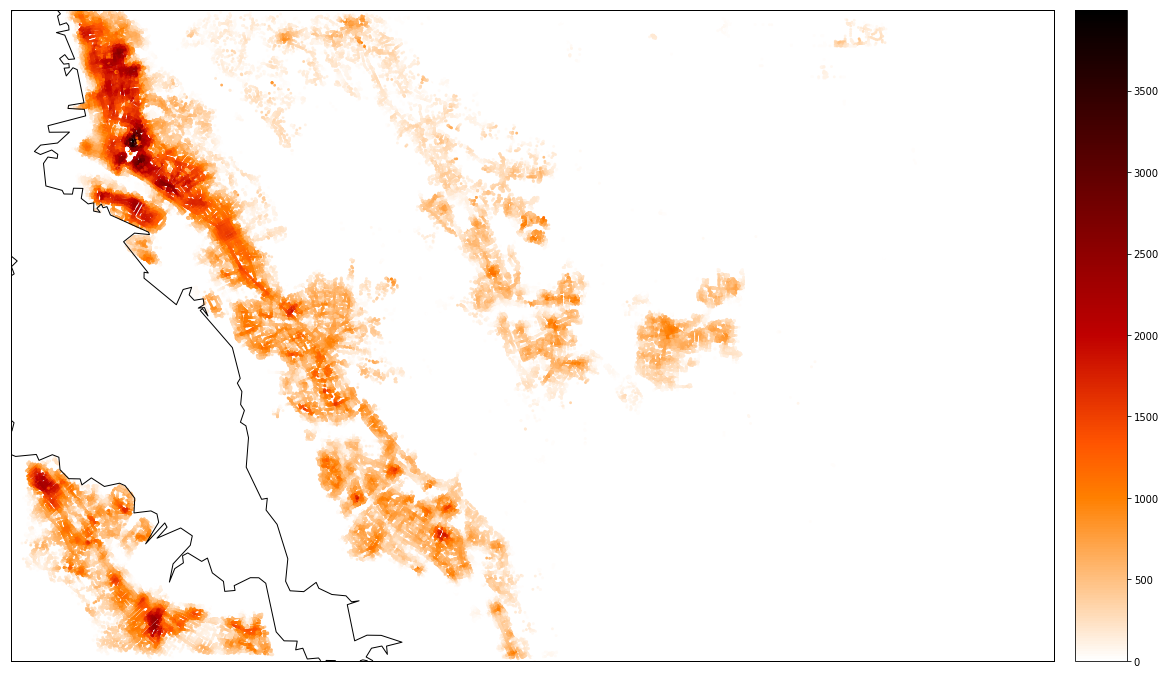

In [45]:
drive_net.plot(workers_1000, 
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         bmap_kwargs={'epsg':'26943','resolution':'h'},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})